In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
from sklearn.cluster import KMeans 
import plotly
plotly.offline.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df_prescaling = pd.read_csv('../../data/banking_transactions_output_data/df_encoded.csv')
# df_prescaling = pd.read_csv('df_encoded.csv')
df_prescaling.head()

,creditSpendtoLimitRatio,averageMonthlySpending,numTnxMonthlyAverage,numAccounts,incomeToSavingsRanking
0,0.000000,0.000000,0.000000,0,2
1,-0.046533,-114.890833,4.333333,3,3
2,0.031669,0.000000,0.000000,2,1
3,0.200000,-40.327500,7.750000,3,1
4,0.173563,-494.062727,9.000000,3,1


# K clustering

In [16]:
## Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

scaler = MinMaxScaler()

tmp = scaler.fit_transform(df_prescaling)
df = pd.DataFrame(tmp, columns=df_prescaling.columns)
df.describe()

,creditSpendtoLimitRatio,averageMonthlySpending,numTnxMonthlyAverage,numAccounts,incomeToSavingsRanking
count,747.000000,747.000000,747.000000,747.000000,747.000000
mean,0.489101,0.606387,0.285391,0.623382,0.483936
std,0.144499,0.122037,0.218216,0.330733,0.264162
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.452482,0.552406,0.000000,0.333333,0.375000
50%,0.500000,0.660270,0.412500,0.666667,0.500000
75%,0.502980,0.666667,0.450000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Elbow method

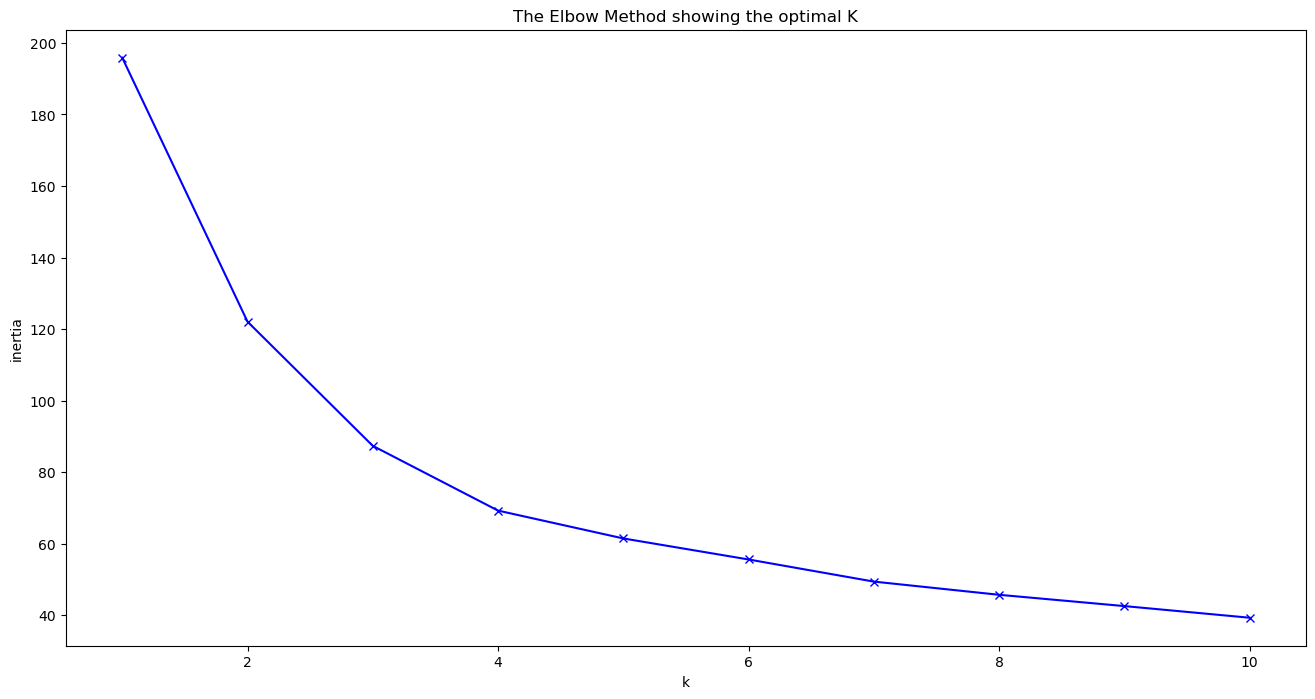

In [17]:
#elbow method
inertias = []
K = range(1,11) #run K-means with K ranging from 2 to 10
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    inertias.append(kmeanModel.inertia_)
    
# plot elbow method
plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal K')
plt.show()

The elbow seems to sharpen at 4?

## Silhouette method

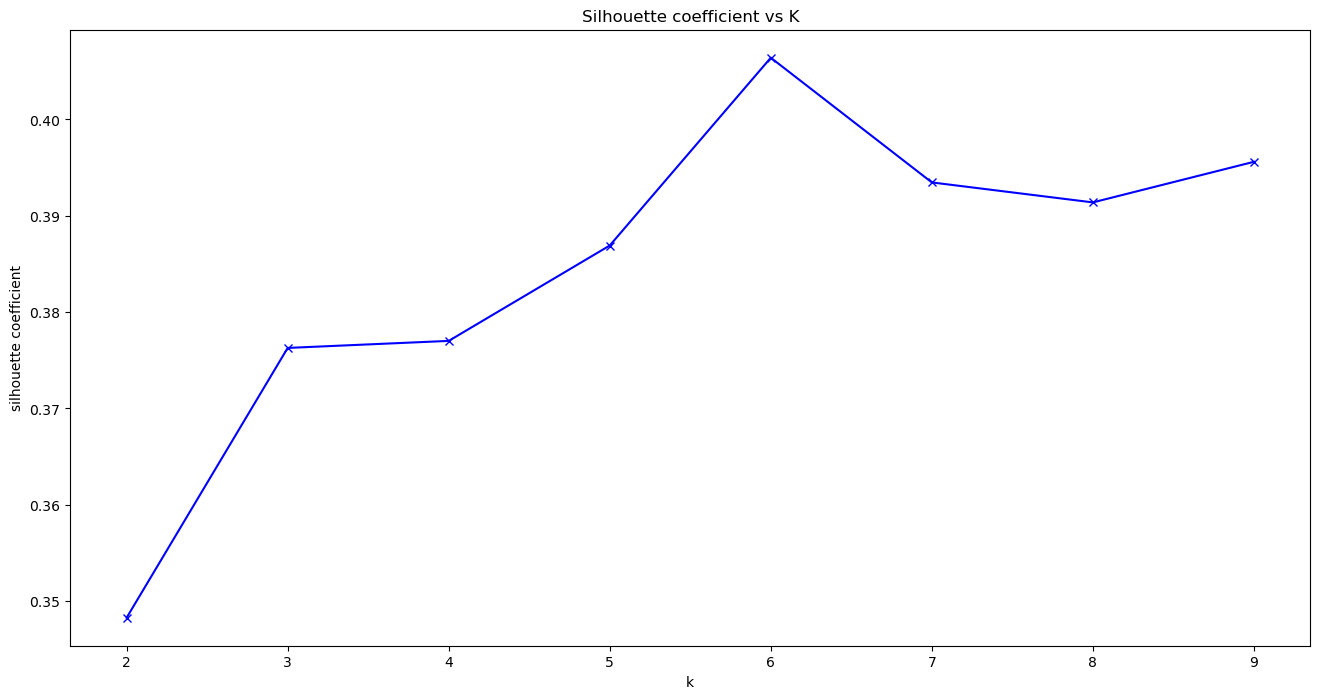

In [18]:
from sklearn.metrics import silhouette_score
silhouettes = []
K = range(2,10) #run K-means with K ranging from 2 to 10
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    label=kmeanModel.predict(df)
    silhouettes.append(silhouette_score(df,label))
    
# plot silhouette
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.title('Silhouette coefficient vs K')
plt.show()

In [19]:
# fitting with the optimum n_clusters

kmeanModel = KMeans(n_clusters=6).fit(df)
cluster_means = kmeanModel.cluster_centers_
pd.DataFrame(cluster_means, columns=df.columns)

,creditSpendtoLimitRatio,averageMonthlySpending,numTnxMonthlyAverage,numAccounts,incomeToSavingsRanking
0,0.508795,0.565711,3.874658e-01,9.887955e-01,0.111345
1,0.492815,0.576833,4.386294e-01,5.705968e-01,0.507642
2,0.500000,0.666667,5.551115e-17,-1.110223e-16,0.500000
3,0.463617,0.583260,4.234233e-01,9.690476e-01,0.826786
4,0.483560,0.663645,1.431364e-02,4.005376e-01,0.552419
5,0.492100,0.659140,1.072752e-01,6.153846e-01,0.120192


In [20]:
df.columns

Index(['creditSpendtoLimitRatio', 'averageMonthlySpending',
       'numTnxMonthlyAverage', 'numAccounts', 'incomeToSavingsRanking'],
      dtype='object')

## Visualize with Radial plot

In [21]:
import plotly.graph_objects as go

for i, cluster in enumerate(cluster_means):
    
    columns = list(df.columns)
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
          r=cluster,
          theta=columns,
          fill='toself',
          name='Cluster ' + str(i)
    ))


    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 2]
        )),
      showlegend=True
    )

    fig.show()

# PCA for visualization

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
df_pca = pca.fit(df)
df_pca

PCA()

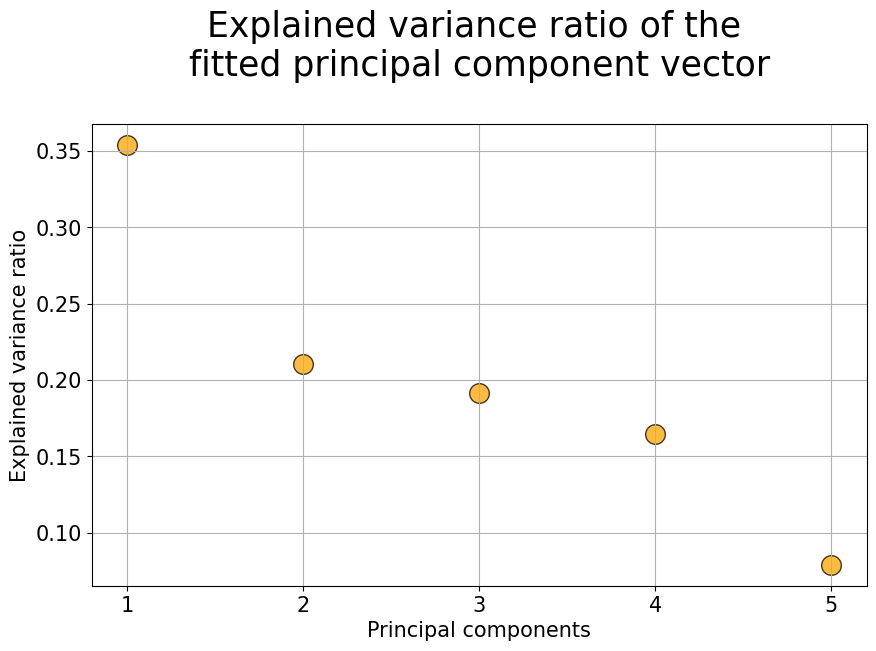

In [11]:
# Expanded variance ratio

plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_pca.explained_variance_ratio_))],
            y=df_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

**Note**: Looks like the first 4 principal components are significant. Well I can only plot a 2D image with the first 2. :()

## Visualizing class separation with PCA

In [23]:
# applying K-clusters method to the PCA 
labels = kmeanModel.fit_predict(pca.transform(df))

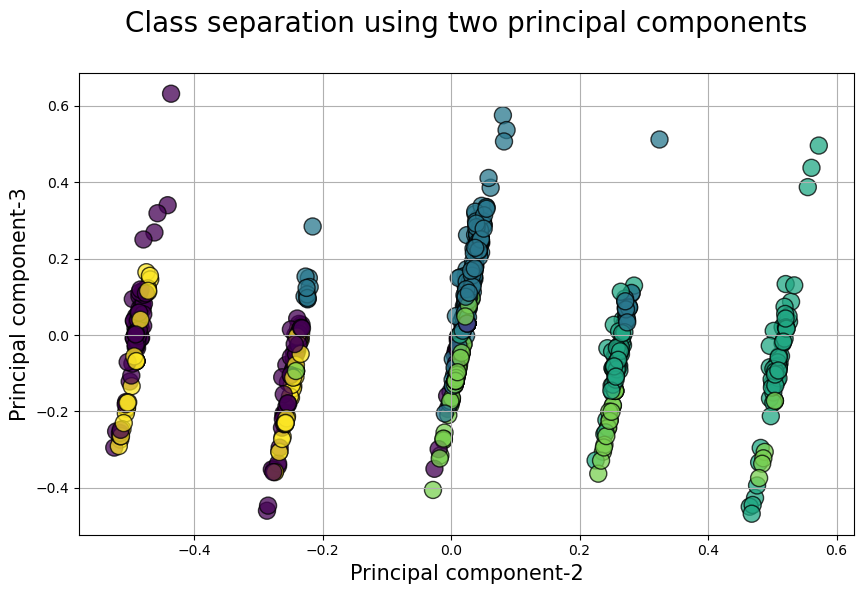

In [24]:
# plot the scatter diagram

df_trans = pca.transform(df)
df_trans = pd.DataFrame(data=df_trans)

plt.figure(figsize=(10,6))
plt.scatter(df_trans[1],df_trans[2],c=labels,edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using two principal components\n",fontsize=20)
plt.xlabel("Principal component-2",fontsize=15)
plt.ylabel("Principal component-3",fontsize=15)
plt.show()
